In [1]:
# This is only valid when the package is not installed
import sys
sys.path.append('../../') # two folders up

In [2]:
import DeepINN as dp

Using default backend: PyTorch
Using Pytorch:  2.0.1+cu117


In [3]:
from torch import nn
import torch

# Test 1

In [4]:
x = torch.tensor([2.0], requires_grad = True)
print("x:", x)

y = x**2 + 1
print("y:", y)

x: tensor([2.], requires_grad=True)
y: tensor([5.], grad_fn=<AddBackward0>)


$$y=x^2 +1$$

$$\frac{dy}{dx} = 2x$$

In [5]:
# Calculate the gradient manually using torch.autograd.grad()
gradient = torch.autograd.grad(y, x, retain_graph=True)[0]
print("Gradient (dy/dx):", gradient)

Gradient (dy/dx): tensor([4.])


In [6]:
jacobian = dp.constraint.Jacobian(x, y)(0,0)
# jacobian_matrix = jacobian(0, 1)
jacobian

tensor([4.])

# A note for the future.
If we need to use the same graph to computer more gradients then we need to use retain_graph=True
We need to investigate whether we need this.

here we confirmed that both compute the same gradient. 

# 1D tensor with multiple values.

In [7]:
# Define a simple neural network for demonstration
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear = nn.Linear(2, 1) # automatic weights initialisation

    def forward(self, x):
        return self.linear(x)

In [8]:
# Create random input tensor
X = torch.tensor([1.0, 2.0], requires_grad=True)
X, X.size()

(tensor([1., 2.], requires_grad=True), torch.Size([2]))

In [9]:
# Instantiate the neural network
net = Net()

# Forward pass
y = net(X)
y

tensor([1.7470], grad_fn=<AddBackward0>)

In [10]:
# pytorch gradient
# Calculate the gradient manually using torch.autograd.grad()
gradient = torch.autograd.grad(y, X, retain_graph=True)[0]
print("Gradient (dy/dx):", gradient)

Gradient (dy/dx): tensor([0.6625, 0.2891])


In [11]:
jacobian = dp.constraint.Jacobian(X, y)(0,0)
jacobian

tensor([0.6625, 0.2891])

Again we verified that dp and torch are giving the same results.

Let us do a manual forward prop for fun.

In [12]:
# Manually compute gradient
weights = net.linear.weight
biases = net.linear.bias

In [13]:
output = torch.matmul(X, weights.t()) + biases
y, output # notice both are same. ok I am stupid

(tensor([1.7470], grad_fn=<AddBackward0>),
 tensor([1.7470], grad_fn=<AddBackward0>))

# 2D tensor

In [14]:
# Create a 2D input tensor
X = torch.tensor([[1.0, 2.0], [3.0, 4.0]], requires_grad=True)
print("X:\n", X)

X:
 tensor([[1., 2.],
        [3., 4.]], requires_grad=True)


In [15]:
# Define a function that operates on the input tensor
def func(x):
    return torch.sin(x)

In [16]:
# Compute the output tensor
y = func(X)
print("y:\n", y)

y:
 tensor([[ 0.8415,  0.9093],
        [ 0.1411, -0.7568]], grad_fn=<SinBackward0>)


In [17]:
# pytorch gradient
# Calculate the gradient manually using torch.autograd.grad()
gradient = torch.autograd.grad(y, X, grad_outputs=torch.ones_like(y), retain_graph=True)[0]
print("Gradient (dy/dx):", gradient)

Gradient (dy/dx): tensor([[ 0.5403, -0.4161],
        [-0.9900, -0.6536]])


In [18]:
# Instantiate the Jacobian module
jacobian = dp.constraint.Jacobian(X, y)

says the first column denotes x-coodinates and the the second column denotes the y-coordintes.

In [19]:
# dy/dx-coordinates, dy/dy-coordinates 
jacobian(0, 0), jacobian(0, 1)

(tensor([[ 0.5403],
         [-0.9900]], grad_fn=<IndexBackward0>),
 tensor([[-0.4161],
         [-0.6536]], grad_fn=<IndexBackward0>))

# Gradients with actual geometry

In [20]:
# Let us make a simple rectangle
X = dp.spaces.R2('x') #  2D space stencil
R = dp.domains.Parallelogram(X, [0,0], [1,0], [0,1])

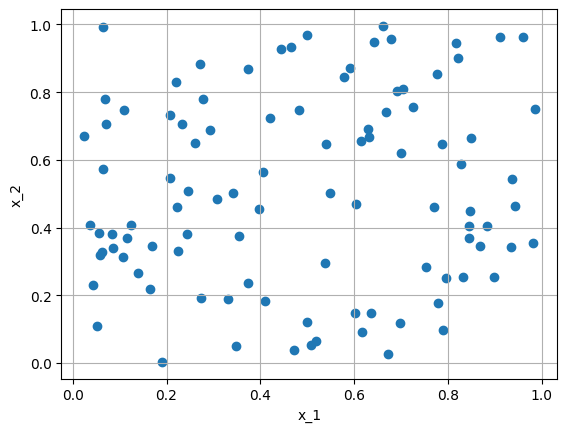

In [21]:
collocation_points = dp.samplers.RandomUniformSampler(R, n_points = 100)
dp.utils.scatter(X, collocation_points)

In [22]:
# sample collcocation points
collocation_points = dp.constraint.PDE(geom = R,
                                       sampling_strategy= "random",
                                       no_points = 100)

In [23]:
collocation_points_sampled = collocation_points.sampler_object().sample_points().as_tensor
collocation_points_sampled.size()

torch.Size([100, 2])

In [24]:
collocation_points_labels = collocation_points.sample_labels(collocation_points_sampled).unsqueeze(1)
collocation_points_labels.size()

torch.Size([100, 1])

In [25]:
import matplotlib.pyplot as plt

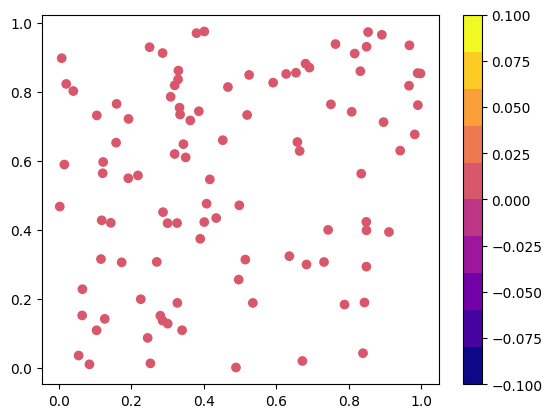

In [26]:
# The variation in BCs based on the provided function : lambda X: X[:,0]**2
plt.scatter(collocation_points_sampled[:,0], collocation_points_sampled[:,1], c = collocation_points_labels, cmap=plt.get_cmap('plasma',10))
plt.colorbar()

In [27]:
collocation_points_sampled.requires_grad = True # enable chain rule

# to differentiate a function, we need an actual function/neural network which take the collocation_points_sampled as the input and outputs the y
y = (collocation_points_sampled[:,0] ** 2).unsqueeze(1) + collocation_points_labels
y.size()

torch.Size([100, 1])

In [28]:
# pytorch gradient
# Calculate the gradient manually using torch.autograd.grad()
gradient = torch.autograd.grad(y, collocation_points_sampled, grad_outputs=torch.ones_like(y), retain_graph=True)[0]
print("Gradient (dy/dx):", gradient)

Gradient (dy/dx): tensor([[1.6971, 0.0000],
        [0.2096, 0.0000],
        [1.6980, 0.0000],
        [0.6550, 0.0000],
        [1.9959, 0.0000],
        [0.5019, 0.0000],
        [0.7608, 0.0000],
        [0.1315, 0.0000],
        [0.4378, 0.0000],
        [0.6671, 0.0000],
        [0.2377, 0.0000],
        [1.9816, 0.0000],
        [1.0509, 0.0000],
        [0.2881, 0.0000],
        [0.5613, 0.0000],
        [0.3172, 0.0000],
        [0.3480, 0.0000],
        [1.9644, 0.0000],
        [0.2433, 0.0000],
        [1.6691, 0.0000],
        [1.6644, 0.0000],
        [0.6180, 0.0000],
        [0.8693, 0.0000],
        [0.0422, 0.0000],
        [1.6977, 0.0000],
        [0.2338, 0.0000],
        [0.1105, 0.0000],
        [0.9783, 0.0000],
        [1.5020, 0.0000],
        [0.5738, 0.0000],
        [0.2109, 0.0000],
        [0.5761, 0.0000],
        [0.7736, 0.0000],
        [0.3855, 0.0000],
        [1.1833, 0.0000],
        [0.7011, 0.0000],
        [0.7264, 0.0000],
        [0.1301, 0.0

In [29]:
# Instantiate the Jacobian module
jacobian = dp.constraint.Jacobian(collocation_points_sampled, y)

In [30]:
# dy/dx-coordinates, 
jacobian(i = 0, j = 0)

tensor([[1.6971],
        [0.2096],
        [1.6980],
        [0.6550],
        [1.9959],
        [0.5019],
        [0.7608],
        [0.1315],
        [0.4378],
        [0.6671],
        [0.2377],
        [1.9816],
        [1.0509],
        [0.2881],
        [0.5613],
        [0.3172],
        [0.3480],
        [1.9644],
        [0.2433],
        [1.6691],
        [1.6644],
        [0.6180],
        [0.8693],
        [0.0422],
        [1.6977],
        [0.2338],
        [0.1105],
        [0.9783],
        [1.5020],
        [0.5738],
        [0.2109],
        [0.5761],
        [0.7736],
        [0.3855],
        [1.1833],
        [0.7011],
        [0.7264],
        [0.1301],
        [1.5770],
        [0.8034],
        [1.8839],
        [1.6331],
        [0.3845],
        [1.3171],
        [0.0173],
        [0.9338],
        [1.9327],
        [1.9801],
        [1.2726],
        [0.6012],
        [0.5737],
        [0.5064],
        [0.6403],
        [1.8220],
        [0.3200],
        [0

In [31]:
#dy/dy-coordinates 
jacobian(i = 0, j = 1)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      